# Exercise Sheet 3: Multi Layer Perceptrons (MLPs)

In [353]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.datasets import make_moons

import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 4.0)

import pprint
pp = pprint.PrettyPrinter(indent=4)


# Set random seed for reproducibility
SEED = 42
RESULTS_PATH = "./results"

### Task 1: Backpropagation and Simple Training

In [354]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

#set_seed(SEED)

In [355]:
def standard_normalization(x):
    """Default normalization function. Normalizes the input x."""
    return (x - x.mean()) / x.std()

def moving_average(x, w):
    """Compute the moving average of x with window size w."""
    return np.convolve(x, np.ones(w), 'valid') / w

def normaldist_init(input_size, output_size):
    """Get some random numbers based on Normal Distribution to initialize weights."""
    # Normal distribution initialization
    return torch.randn(input_size, output_size)
    
def xavier_init(input_size, output_size):
    """ Get some random number to initialize weights."""
    # Xavier initialization
    return torch.randn(input_size, output_size) * np.sqrt(2.0/(input_size + output_size))

In [356]:
# 1. Complete forward, backward pass, and update for Linear and ReLU
class Linear:
    def __init__(self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # initialize weights with standard normal distribution and bias with zeros
        # self.weight = normaldist_init(self.in_channels, self.out_channels)
        
        # Xavier initialization
        self.weight = xavier_init(self.in_channels, self.out_channels)
        self.bias = torch.zeros(self.out_channels)
        
        # store last input for backpropagation
        self.last_input = None
        self.grad_weight = None
        self.grad_bias = None
        
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x

        # reshape input to 2D tensor
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # calculate linear transformation
        newx = torch.matmul(x, self.weight) + self.bias
        return newx
    
    def backward(self, gradient):
        # calculate gradients
        self.grad_weight = torch.matmul(self.last_input.t(), gradient)
        self.grad_bias = torch.sum(gradient, dim=0)
        
        # reshape gradient to original input shape
        if len(self.last_input.shape) > 2:
            gradient = gradient.view(*self.last_input.shape)

        # calculate gradient for previous layer
        newgrad = torch.matmul(gradient, self.weight.t())

        return newgrad

    
    def update(self, learning_rate):
        # update weights and bias
        self.weight -= learning_rate * self.grad_weight
        self.bias -= learning_rate * self.grad_bias
        
        
class ReLU:
    def __init__(self):
        self.last_input = None
    
    def forward(self, x, remember=False):
        if remember:
            self.last_input = x
        
        # ReLU activation
        newx = torch.max(x, torch.zeros_like(x))
        return newx
    
    def backward(self, gradient):
        # ReLU gradient - check where input is larger than zero return 1, else 0
        newgrad = torch.where(self.last_input>0, gradient, 0.0)
        return newgrad
    
    def update(self, learning_rate):
        # we don't have any parameters in ReLU layer here
        # other ReLU activations can have parameters that might need to be learned
        pass
    

In [357]:
class Softmax:
    """ Numerically stable Softmax implementation since we take the max() 
        of the input per samples not per batch. 
        We constrain it into a range of 0 to 1.
    """
    def __init__(self, dim=-1):
        self.last_output = None
        self.dim = dim
        
    def forward(self, x, remember=False):
        x = torch.exp(x - torch.amax(x, dim=-1, keepdims=True)) # numerical stable version -> normalize by max(x) over the last dimension
        x = x/(torch.sum(x, dim=self.dim, keepdim=True)+1e-12)
        if remember:
            self.last_output = x
        return x
    
    def backward(self, gradient):
        jacobian = -self.last_output[:,:,None]*self.last_output[:,None,:] #BxLxL
        #correct diagonal entries
        jacobian += torch.eye(self.last_output.size(-1)).unsqueeze(0)*self.last_output.unsqueeze(-1).repeat(1,1,self.last_output.size(-1))
        # you can use any character, but make sure they are consistent
        return torch.einsum("bj,bji->bi", gradient, jacobian)
    
    def update(self, learning_rate):
        #we don't have any parameters here
        pass

In [358]:
class CrossEntropyLoss:
    def __init__(self, dim=-1):
        self.last_input = None
        self.last_ground_truth = None
        self.dim = dim
    
    def forward(self, p, y):
        #convert y to one hot
        one_hot = torch.eye(p.size(-1))[y]
        self.last_input = p
        self.last_ground_truth = one_hot
        
        losses = -torch.sum(one_hot*torch.log(p), dim=-1)
        total_loss = torch.mean(losses)
        
        return total_loss
    
    def backward(self):
        return torch.where(self.last_ground_truth==1,-1.0/self.last_input, 0.0)

In [359]:
class MLP:
    def __init__(self, in_channels=2, hidden_channels=[], out_channels=2):
        self.in_channels = in_channels
        
        self.layers = []
        if len(hidden_channels)==0:
            self.layers.append(Linear(in_channels, out_channels))
        else:
            self.layers.append(Linear(in_channels, hidden_channels[0]))
            self.layers.append(ReLU())
            for i in range(len(hidden_channels)-1):
                self.layers.append(Linear(hidden_channels[i], hidden_channels[i+1]))
                self.layers.append(ReLU())
            self.layers.append(Linear(hidden_channels[-1], out_channels))
        self.layers.append(Softmax(dim=-1))
        
        self.criterion = CrossEntropyLoss(dim=-1)
        
    def forward(self, x, remember=False):
        for layer in self.layers:
            x = layer.forward(x, remember=remember)
        return x
    
    def backward(self): #calculate gradients
        grad = self.criterion.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def update(self, learning_rate): #update each layer via gradient descent
        for layer in self.layers:
            layer.update(learning_rate)
    
    def training_step(self, x, y, learning_rate):
        probabilities = self.forward(x, remember=True) #store inputs for backward pass!
        loss = self.criterion.forward(probabilities, y)
        self.backward() #calculate gradients
        self.update(learning_rate) #update using gradient descent
        
        return loss

In [360]:
def train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=10, batch_size=32, learning_rate=5e-3):
    num_batches_train = int(np.ceil(Ntrain/batch_size))
    num_batches_test = int(np.ceil(Ntest/batch_size))

    #train network
    losses_train = []
    losses_test = []

    for epoch in range(num_epochs):
        #reshuffle training data
        ind = np.random.permutation(len(Xtrain))
        Xtrain = Xtrain[ind]
        ytrain = ytrain[ind]

        # loss per epoch
        epoch_train_loss = 0.0
        epoch_test_loss = 0.0

        #training pass
        for it in tqdm(range(num_batches_train)):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtrain))
            X = torch.FloatTensor(Xtrain[start:end])
            y = torch.LongTensor(ytrain[start:end])

            # compute loss and update weights
            loss = mlp.training_step(X, y, learning_rate)
            epoch_train_loss += loss.item()

            # update weights
            mlp.update(learning_rate)

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_train}, Train Loss: {loss.item()}")

        #testing pass
        for it in range(num_batches_test):
            start = it*batch_size
            end = min((it+1)*batch_size, len(Xtest))
            X = torch.FloatTensor(Xtest[start:end])
            y = torch.LongTensor(ytest[start:end])

            # compute loss
            probabilities = mlp.forward(X)
            loss = mlp.criterion.forward(probabilities, y)
            epoch_test_loss += loss.item()

            if it%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Iteration {it+1}/{num_batches_test}, Test Loss: {loss.item()}")

        # append average loss for this epoch
        losses_train.append(epoch_train_loss / num_batches_train)
        losses_test.append(epoch_test_loss / num_batches_test)

    return losses_train, losses_test


In [361]:
#create datasets
Ntrain = 8000
Ntest = 2000
Xtrain, ytrain = make_moons(n_samples=Ntrain, noise=0.1, random_state=42)
Xtest, ytest = make_moons(n_samples=Ntest, noise=0.1, random_state=42)

print(Xtrain.shape, ytrain.shape)

(8000, 2) (8000,)


In [362]:
# 2. Implement missing parts in the training routine

# rescale data (normalise) to [-1,1]
amin = np.amin(Xtrain, axis=0, keepdims=True)
amax = np.amax(Xtrain, axis=0, keepdims=True)

Xtrain = ((Xtrain-amin)/(amax-amin)-0.5)/0.5
Xtest = ((Xtest-amin)/(amax-amin)-0.5)/0.5

batch_size = 32
num_epochs = 10
learning_rate = 3e-2

# create MLP
hidden_channels = [30,30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)


100%|██████████| 250/250 [00:00<00:00, 5258.68it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6342665553092957
Epoch 1/10, Iteration 11/250, Train Loss: 0.28664568066596985
Epoch 1/10, Iteration 21/250, Train Loss: 0.3239789605140686
Epoch 1/10, Iteration 31/250, Train Loss: 0.19605225324630737
Epoch 1/10, Iteration 41/250, Train Loss: 0.23243273794651031
Epoch 1/10, Iteration 51/250, Train Loss: 0.13898007571697235
Epoch 1/10, Iteration 61/250, Train Loss: 0.27341848611831665
Epoch 1/10, Iteration 71/250, Train Loss: 0.14051441848278046
Epoch 1/10, Iteration 81/250, Train Loss: 0.07703292369842529
Epoch 1/10, Iteration 91/250, Train Loss: 0.0744333267211914
Epoch 1/10, Iteration 101/250, Train Loss: 0.023060385137796402
Epoch 1/10, Iteration 111/250, Train Loss: 0.10532379895448685
Epoch 1/10, Iteration 121/250, Train Loss: 0.036254722625017166
Epoch 1/10, Iteration 131/250, Train Loss: 0.0037309378385543823
Epoch 1/10, Iteration 141/250, Train Loss: 0.019721560180187225
Epoch 1/10, Iteration 151/250, Train Loss: 0.17876765131950378
E

100%|██████████| 250/250 [00:00<00:00, 5322.56it/s]


Epoch 2/10, Iteration 1/250, Train Loss: 0.02407226525247097
Epoch 2/10, Iteration 11/250, Train Loss: 0.024511072784662247
Epoch 2/10, Iteration 21/250, Train Loss: 0.018552331253886223
Epoch 2/10, Iteration 31/250, Train Loss: 0.01710604690015316
Epoch 2/10, Iteration 41/250, Train Loss: 0.009045710787177086
Epoch 2/10, Iteration 51/250, Train Loss: 0.004835070110857487
Epoch 2/10, Iteration 61/250, Train Loss: 0.007329490501433611
Epoch 2/10, Iteration 71/250, Train Loss: 0.2324441820383072
Epoch 2/10, Iteration 81/250, Train Loss: 0.09251226484775543
Epoch 2/10, Iteration 91/250, Train Loss: 0.22622284293174744
Epoch 2/10, Iteration 101/250, Train Loss: 0.018152907490730286
Epoch 2/10, Iteration 111/250, Train Loss: 0.019288253039121628
Epoch 2/10, Iteration 121/250, Train Loss: 0.002178642898797989
Epoch 2/10, Iteration 131/250, Train Loss: 0.0015498566208407283
Epoch 2/10, Iteration 141/250, Train Loss: 0.007218053098767996
Epoch 2/10, Iteration 151/250, Train Loss: 0.00637841410

100%|██████████| 250/250 [00:00<00:00, 5257.39it/s]


Epoch 3/10, Iteration 1/250, Train Loss: 0.005775170400738716
Epoch 3/10, Iteration 11/250, Train Loss: 0.003644082462415099
Epoch 3/10, Iteration 21/250, Train Loss: 0.1480347067117691
Epoch 3/10, Iteration 31/250, Train Loss: 0.0021286169067025185
Epoch 3/10, Iteration 41/250, Train Loss: 0.005528975743800402
Epoch 3/10, Iteration 51/250, Train Loss: 0.0009981247130781412
Epoch 3/10, Iteration 61/250, Train Loss: 0.0016167808789759874
Epoch 3/10, Iteration 71/250, Train Loss: 0.0006046358030289412
Epoch 3/10, Iteration 81/250, Train Loss: 0.00013620602840092033
Epoch 3/10, Iteration 91/250, Train Loss: 0.00040762496064417064
Epoch 3/10, Iteration 101/250, Train Loss: 0.0014370143180713058
Epoch 3/10, Iteration 111/250, Train Loss: 0.0016895858570933342
Epoch 3/10, Iteration 121/250, Train Loss: 0.0007670139311812818
Epoch 3/10, Iteration 131/250, Train Loss: 0.001122566289268434
Epoch 3/10, Iteration 141/250, Train Loss: 0.0017025332199409604
Epoch 3/10, Iteration 151/250, Train Loss

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: 0.001437222003005445
Epoch 4/10, Iteration 11/250, Train Loss: 0.002844878239557147
Epoch 4/10, Iteration 21/250, Train Loss: 0.00023108298773877323
Epoch 4/10, Iteration 31/250, Train Loss: 0.00015913606330286711
Epoch 4/10, Iteration 41/250, Train Loss: 0.000401336612412706
Epoch 4/10, Iteration 51/250, Train Loss: 8.643029286758974e-05
Epoch 4/10, Iteration 61/250, Train Loss: 3.265839768573642e-05
Epoch 4/10, Iteration 71/250, Train Loss: 4.987040301784873e-05
Epoch 4/10, Iteration 81/250, Train Loss: 0.0010062303626909852
Epoch 4/10, Iteration 91/250, Train Loss: 0.000807195610832423
Epoch 4/10, Iteration 101/250, Train Loss: 0.0005194690311327577
Epoch 4/10, Iteration 111/250, Train Loss: 0.0002725634549278766
Epoch 4/10, Iteration 121/250, Train Loss: 0.001350218546576798
Epoch 4/10, Iteration 131/250, Train Loss: 0.0001438319741282612
Epoch 4/10, Iteration 141/250, Train Loss: 0.034295324236154556
Epoch 4/10, Iteration 151/250, Train Los

100%|██████████| 250/250 [00:00<00:00, 5046.01it/s]


Epoch 4/10, Iteration 231/250, Train Loss: 0.00040688784793019295
Epoch 4/10, Iteration 241/250, Train Loss: 0.0002149707725038752
Epoch 4/10, Iteration 1/63, Test Loss: 0.08533491939306259
Epoch 4/10, Iteration 11/63, Test Loss: 0.0453958660364151
Epoch 4/10, Iteration 21/63, Test Loss: 0.190669983625412
Epoch 4/10, Iteration 31/63, Test Loss: 0.2670798897743225
Epoch 4/10, Iteration 41/63, Test Loss: 0.015496127307415009
Epoch 4/10, Iteration 51/63, Test Loss: 0.008221996948122978
Epoch 4/10, Iteration 61/63, Test Loss: 0.013931762427091599


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: 0.10143237560987473
Epoch 5/10, Iteration 11/250, Train Loss: 0.0011123691219836473
Epoch 5/10, Iteration 21/250, Train Loss: 0.0003124714130535722
Epoch 5/10, Iteration 31/250, Train Loss: 0.005081383977085352
Epoch 5/10, Iteration 41/250, Train Loss: 0.0023026594426482916
Epoch 5/10, Iteration 51/250, Train Loss: 0.0026503417175263166
Epoch 5/10, Iteration 61/250, Train Loss: 0.0006489561637863517
Epoch 5/10, Iteration 71/250, Train Loss: 0.0003817301185335964
Epoch 5/10, Iteration 81/250, Train Loss: 0.0001095185725716874
Epoch 5/10, Iteration 91/250, Train Loss: 0.00020963765564374626
Epoch 5/10, Iteration 101/250, Train Loss: 0.0001254659437108785
Epoch 5/10, Iteration 111/250, Train Loss: 4.1773942939471453e-05
Epoch 5/10, Iteration 121/250, Train Loss: 0.0020872207824140787
Epoch 5/10, Iteration 131/250, Train Loss: 0.021550189703702927
Epoch 5/10, Iteration 141/250, Train Loss: 0.00037291794433258474
Epoch 5/10, Iteration 151/250, Train 

100%|██████████| 250/250 [00:00<00:00, 5244.93it/s]


Epoch 5/10, Iteration 221/250, Train Loss: 0.0005211597890593112
Epoch 5/10, Iteration 231/250, Train Loss: 0.00018168801034335047
Epoch 5/10, Iteration 241/250, Train Loss: 0.006105269305408001
Epoch 5/10, Iteration 1/63, Test Loss: 0.0001780260936357081
Epoch 5/10, Iteration 11/63, Test Loss: 3.880531949107535e-05
Epoch 5/10, Iteration 21/63, Test Loss: 0.00016105431132018566
Epoch 5/10, Iteration 31/63, Test Loss: 0.0002706800296436995
Epoch 5/10, Iteration 41/63, Test Loss: 9.957932343240827e-05
Epoch 5/10, Iteration 51/63, Test Loss: 0.00019117591727990657
Epoch 5/10, Iteration 61/63, Test Loss: 0.00010422701598145068


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: 0.00011506598093546927
Epoch 6/10, Iteration 11/250, Train Loss: 0.00014178917626850307
Epoch 6/10, Iteration 21/250, Train Loss: 0.1566033959388733
Epoch 6/10, Iteration 31/250, Train Loss: 0.006056377198547125
Epoch 6/10, Iteration 41/250, Train Loss: 0.0008283974602818489
Epoch 6/10, Iteration 51/250, Train Loss: 0.0006236667977645993
Epoch 6/10, Iteration 61/250, Train Loss: 0.00012966309441253543
Epoch 6/10, Iteration 71/250, Train Loss: 0.00040584360249340534
Epoch 6/10, Iteration 81/250, Train Loss: 0.00216233660466969
Epoch 6/10, Iteration 91/250, Train Loss: 0.0008705419022589922
Epoch 6/10, Iteration 101/250, Train Loss: 0.004326789174228907
Epoch 6/10, Iteration 111/250, Train Loss: 0.0007994749466888607
Epoch 6/10, Iteration 121/250, Train Loss: 0.00011663004261208698
Epoch 6/10, Iteration 131/250, Train Loss: 0.0001455294550396502
Epoch 6/10, Iteration 141/250, Train Loss: 0.00040953574352897704
Epoch 6/10, Iteration 151/250, Train 

100%|██████████| 250/250 [00:00<00:00, 5283.06it/s]


Epoch 6/10, Iteration 221/250, Train Loss: 0.00011462393740657717
Epoch 6/10, Iteration 231/250, Train Loss: 4.811809412785806e-05
Epoch 6/10, Iteration 241/250, Train Loss: 0.00046606676187366247
Epoch 6/10, Iteration 1/63, Test Loss: 0.00010229632607661188
Epoch 6/10, Iteration 11/63, Test Loss: 2.5604960683267564e-05
Epoch 6/10, Iteration 21/63, Test Loss: 0.0034547862596809864
Epoch 6/10, Iteration 31/63, Test Loss: 0.00025519393966533244
Epoch 6/10, Iteration 41/63, Test Loss: 6.707708234898746e-05
Epoch 6/10, Iteration 51/63, Test Loss: 0.0001945686381077394
Epoch 6/10, Iteration 61/63, Test Loss: 8.791348955128342e-05


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: 0.00016977376071736217
Epoch 7/10, Iteration 11/250, Train Loss: 0.05319710448384285
Epoch 7/10, Iteration 21/250, Train Loss: 5.512182542588562e-05
Epoch 7/10, Iteration 31/250, Train Loss: 0.022429659962654114
Epoch 7/10, Iteration 41/250, Train Loss: 0.0005772888544015586
Epoch 7/10, Iteration 51/250, Train Loss: 0.00016693225188646466
Epoch 7/10, Iteration 61/250, Train Loss: 0.0007463229121640325
Epoch 7/10, Iteration 71/250, Train Loss: 6.356308585964143e-05
Epoch 7/10, Iteration 81/250, Train Loss: 9.055018017534167e-05
Epoch 7/10, Iteration 91/250, Train Loss: 0.000343119289027527
Epoch 7/10, Iteration 101/250, Train Loss: 0.0007447654497809708
Epoch 7/10, Iteration 111/250, Train Loss: 0.0002906362060457468
Epoch 7/10, Iteration 121/250, Train Loss: 0.009506229311227798
Epoch 7/10, Iteration 131/250, Train Loss: 0.0002525774762034416
Epoch 7/10, Iteration 141/250, Train Loss: 0.00018693449965212494
Epoch 7/10, Iteration 151/250, Train L

100%|██████████| 250/250 [00:00<00:00, 5361.56it/s]


Epoch 7/10, Iteration 231/250, Train Loss: 0.0005371309816837311
Epoch 7/10, Iteration 241/250, Train Loss: 0.0003778379177674651
Epoch 7/10, Iteration 1/63, Test Loss: 0.0006561647169291973
Epoch 7/10, Iteration 11/63, Test Loss: 0.00014326382370200008
Epoch 7/10, Iteration 21/63, Test Loss: 0.0006085728527978063
Epoch 7/10, Iteration 31/63, Test Loss: 0.0033740291837602854
Epoch 7/10, Iteration 41/63, Test Loss: 0.00022123850067146122
Epoch 7/10, Iteration 51/63, Test Loss: 0.0003741239779628813
Epoch 7/10, Iteration 61/63, Test Loss: 0.0002381807571509853


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: 0.0003750043106265366
Epoch 8/10, Iteration 11/250, Train Loss: 0.001463916152715683
Epoch 8/10, Iteration 21/250, Train Loss: 0.0008308415417559445
Epoch 8/10, Iteration 31/250, Train Loss: 0.0006008715135976672
Epoch 8/10, Iteration 41/250, Train Loss: 0.0005727559910155833
Epoch 8/10, Iteration 51/250, Train Loss: 0.00013039416808169335
Epoch 8/10, Iteration 61/250, Train Loss: 0.00013352361565921456
Epoch 8/10, Iteration 71/250, Train Loss: 0.00017480624956078827
Epoch 8/10, Iteration 81/250, Train Loss: 0.0001551116438349709
Epoch 8/10, Iteration 91/250, Train Loss: 8.475665526930243e-05
Epoch 8/10, Iteration 101/250, Train Loss: 8.011605677893385e-05
Epoch 8/10, Iteration 111/250, Train Loss: 0.0003162692009937018
Epoch 8/10, Iteration 121/250, Train Loss: 1.680286914051976e-05
Epoch 8/10, Iteration 131/250, Train Loss: 8.952873758971691e-05
Epoch 8/10, Iteration 141/250, Train Loss: 9.344999125460163e-05
Epoch 8/10, Iteration 151/250, Tra

100%|██████████| 250/250 [00:00<00:00, 5380.76it/s]


Epoch 8/10, Iteration 1/63, Test Loss: 6.60813893773593e-05
Epoch 8/10, Iteration 11/63, Test Loss: 4.9286725698038936e-05
Epoch 8/10, Iteration 21/63, Test Loss: 0.0005087501485832036
Epoch 8/10, Iteration 31/63, Test Loss: 0.00011394698958611116
Epoch 8/10, Iteration 41/63, Test Loss: 6.926314381416887e-05
Epoch 8/10, Iteration 51/63, Test Loss: 0.00036057629040442407
Epoch 8/10, Iteration 61/63, Test Loss: 0.00014388879935722798


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: 0.016109103336930275
Epoch 9/10, Iteration 11/250, Train Loss: 0.057799309492111206
Epoch 9/10, Iteration 21/250, Train Loss: 7.017208554316312e-05
Epoch 9/10, Iteration 31/250, Train Loss: 0.00018291972810402513
Epoch 9/10, Iteration 41/250, Train Loss: 8.30873686936684e-05
Epoch 9/10, Iteration 51/250, Train Loss: 2.3793189029674977e-05
Epoch 9/10, Iteration 61/250, Train Loss: 7.336426642723382e-05
Epoch 9/10, Iteration 71/250, Train Loss: 2.7886484531336464e-05
Epoch 9/10, Iteration 81/250, Train Loss: 0.00010776129056466743
Epoch 9/10, Iteration 91/250, Train Loss: 0.12232374399900436
Epoch 9/10, Iteration 101/250, Train Loss: 0.0004638223326765001
Epoch 9/10, Iteration 111/250, Train Loss: 0.0008169346256181598
Epoch 9/10, Iteration 121/250, Train Loss: 0.03296716883778572
Epoch 9/10, Iteration 131/250, Train Loss: 0.0008049553143791854
Epoch 9/10, Iteration 141/250, Train Loss: 0.0006321407854557037
Epoch 9/10, Iteration 151/250, Train Lo

100%|██████████| 250/250 [00:00<00:00, 5368.01it/s]


Epoch 9/10, Iteration 1/63, Test Loss: 0.0047310516238212585
Epoch 9/10, Iteration 11/63, Test Loss: 5.9484897064976394e-05
Epoch 9/10, Iteration 21/63, Test Loss: 0.0005195966805331409
Epoch 9/10, Iteration 31/63, Test Loss: 0.00018997490406036377
Epoch 9/10, Iteration 41/63, Test Loss: 0.0002208278456237167
Epoch 9/10, Iteration 51/63, Test Loss: 0.000860522617585957
Epoch 9/10, Iteration 61/63, Test Loss: 0.0004582710098475218


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: 0.008680908940732479
Epoch 10/10, Iteration 11/250, Train Loss: 0.0003535203286446631
Epoch 10/10, Iteration 21/250, Train Loss: 0.08817078173160553
Epoch 10/10, Iteration 31/250, Train Loss: 0.00014999849372543395
Epoch 10/10, Iteration 41/250, Train Loss: 0.00011413550964789465
Epoch 10/10, Iteration 51/250, Train Loss: 5.137407424626872e-05
Epoch 10/10, Iteration 61/250, Train Loss: 0.00033525837352499366
Epoch 10/10, Iteration 71/250, Train Loss: 0.00013600534293800592
Epoch 10/10, Iteration 81/250, Train Loss: 0.009409760124981403
Epoch 10/10, Iteration 91/250, Train Loss: 0.00018190196715295315
Epoch 10/10, Iteration 101/250, Train Loss: 0.00022084120428189635
Epoch 10/10, Iteration 111/250, Train Loss: 0.004293285310268402
Epoch 10/10, Iteration 121/250, Train Loss: 0.0008107790490612388
Epoch 10/10, Iteration 131/250, Train Loss: 0.00042069671326316893
Epoch 10/10, Iteration 141/250, Train Loss: 5.756798782385886e-05
Epoch 10/10, Iterat

100%|██████████| 250/250 [00:00<00:00, 5321.86it/s]

Epoch 10/10, Iteration 1/63, Test Loss: 0.000380749988835305
Epoch 10/10, Iteration 11/63, Test Loss: 4.632381387636997e-05
Epoch 10/10, Iteration 21/63, Test Loss: 7.638898387085646e-05
Epoch 10/10, Iteration 31/63, Test Loss: 0.0003794065851252526
Epoch 10/10, Iteration 41/63, Test Loss: 8.001861715456471e-05
Epoch 10/10, Iteration 51/63, Test Loss: 0.00029779024771414697
Epoch 10/10, Iteration 61/63, Test Loss: 0.00012410270574036986


In [363]:
def plot_loss_curves(losses_train, losses_test, path=RESULTS_PATH, file_name="losses"):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_train, label="Training Loss", marker='o', markersize=4, linestyle='-', color='blue')
    plt.plot(losses_test, label="Testing Loss", marker='o', markersize=4, linestyle='-', color='red')
    plt.title("Loss Curves for Training and Testing Sets", fontsize=16)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)

    # store plot in results folder
    # check if folder exists, if not create it
    if not os.path.exists(path):
        os.makedirs(path)

    plt.savefig(f"{path}/{file_name}.png", dpi=300)
    plt.show()


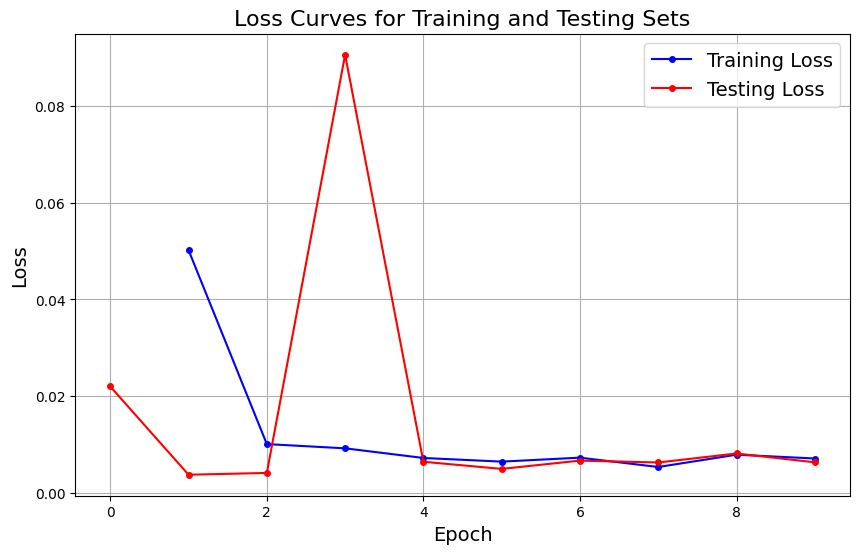

In [364]:
# 3. Plot loss curves on training and test set
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_small_2")

In [365]:
# 4. Increase the number of hidden units and observe the effect on the loss curves
# create MLP
batch_size = 32
num_epochs = 10
learning_rate = 3e-2

hidden_channels = [30, 40, 50, 40, 30]
mlp = MLP(2, hidden_channels, 2)

losses_train = []
losses_test = []

# train network
losses_train, losses_test = train_network(mlp, Ntrain, Ntest, Xtrain, ytrain, Xtest, ytest, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)

100%|██████████| 250/250 [00:00<00:00, 3384.00it/s]


Epoch 1/10, Iteration 1/250, Train Loss: 0.6928396821022034
Epoch 1/10, Iteration 11/250, Train Loss: 0.8972364664077759
Epoch 1/10, Iteration 21/250, Train Loss: nan
Epoch 1/10, Iteration 31/250, Train Loss: nan
Epoch 1/10, Iteration 41/250, Train Loss: nan
Epoch 1/10, Iteration 51/250, Train Loss: nan
Epoch 1/10, Iteration 61/250, Train Loss: nan
Epoch 1/10, Iteration 71/250, Train Loss: nan
Epoch 1/10, Iteration 81/250, Train Loss: nan
Epoch 1/10, Iteration 91/250, Train Loss: nan
Epoch 1/10, Iteration 101/250, Train Loss: nan
Epoch 1/10, Iteration 111/250, Train Loss: nan
Epoch 1/10, Iteration 121/250, Train Loss: nan
Epoch 1/10, Iteration 131/250, Train Loss: nan
Epoch 1/10, Iteration 141/250, Train Loss: nan
Epoch 1/10, Iteration 151/250, Train Loss: nan
Epoch 1/10, Iteration 161/250, Train Loss: nan
Epoch 1/10, Iteration 171/250, Train Loss: nan
Epoch 1/10, Iteration 181/250, Train Loss: nan
Epoch 1/10, Iteration 191/250, Train Loss: nan
Epoch 1/10, Iteration 201/250, Train Loss

100%|██████████| 250/250 [00:00<00:00, 3444.71it/s]


Epoch 2/10, Iteration 1/250, Train Loss: nan
Epoch 2/10, Iteration 11/250, Train Loss: nan
Epoch 2/10, Iteration 21/250, Train Loss: nan
Epoch 2/10, Iteration 31/250, Train Loss: nan
Epoch 2/10, Iteration 41/250, Train Loss: nan
Epoch 2/10, Iteration 51/250, Train Loss: nan
Epoch 2/10, Iteration 61/250, Train Loss: nan
Epoch 2/10, Iteration 71/250, Train Loss: nan
Epoch 2/10, Iteration 81/250, Train Loss: nan
Epoch 2/10, Iteration 91/250, Train Loss: nan
Epoch 2/10, Iteration 101/250, Train Loss: nan
Epoch 2/10, Iteration 111/250, Train Loss: nan
Epoch 2/10, Iteration 121/250, Train Loss: nan
Epoch 2/10, Iteration 131/250, Train Loss: nan
Epoch 2/10, Iteration 141/250, Train Loss: nan
Epoch 2/10, Iteration 151/250, Train Loss: nan
Epoch 2/10, Iteration 161/250, Train Loss: nan
Epoch 2/10, Iteration 171/250, Train Loss: nan
Epoch 2/10, Iteration 181/250, Train Loss: nan
Epoch 2/10, Iteration 191/250, Train Loss: nan
Epoch 2/10, Iteration 201/250, Train Loss: nan
Epoch 2/10, Iteration 21

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/10, Iteration 1/250, Train Loss: nan
Epoch 3/10, Iteration 11/250, Train Loss: nan
Epoch 3/10, Iteration 21/250, Train Loss: nan
Epoch 3/10, Iteration 31/250, Train Loss: nan
Epoch 3/10, Iteration 41/250, Train Loss: nan
Epoch 3/10, Iteration 51/250, Train Loss: nan
Epoch 3/10, Iteration 61/250, Train Loss: nan
Epoch 3/10, Iteration 71/250, Train Loss: nan
Epoch 3/10, Iteration 81/250, Train Loss: nan
Epoch 3/10, Iteration 91/250, Train Loss: nan
Epoch 3/10, Iteration 101/250, Train Loss: nan
Epoch 3/10, Iteration 111/250, Train Loss: nan
Epoch 3/10, Iteration 121/250, Train Loss: nan
Epoch 3/10, Iteration 131/250, Train Loss: nan
Epoch 3/10, Iteration 141/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3410.74it/s]


Epoch 3/10, Iteration 151/250, Train Loss: nan
Epoch 3/10, Iteration 161/250, Train Loss: nan
Epoch 3/10, Iteration 171/250, Train Loss: nan
Epoch 3/10, Iteration 181/250, Train Loss: nan
Epoch 3/10, Iteration 191/250, Train Loss: nan
Epoch 3/10, Iteration 201/250, Train Loss: nan
Epoch 3/10, Iteration 211/250, Train Loss: nan
Epoch 3/10, Iteration 221/250, Train Loss: nan
Epoch 3/10, Iteration 231/250, Train Loss: nan
Epoch 3/10, Iteration 241/250, Train Loss: nan
Epoch 3/10, Iteration 1/63, Test Loss: nan
Epoch 3/10, Iteration 11/63, Test Loss: nan
Epoch 3/10, Iteration 21/63, Test Loss: nan
Epoch 3/10, Iteration 31/63, Test Loss: nan
Epoch 3/10, Iteration 41/63, Test Loss: nan
Epoch 3/10, Iteration 51/63, Test Loss: nan
Epoch 3/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/10, Iteration 1/250, Train Loss: nan
Epoch 4/10, Iteration 11/250, Train Loss: nan
Epoch 4/10, Iteration 21/250, Train Loss: nan
Epoch 4/10, Iteration 31/250, Train Loss: nan
Epoch 4/10, Iteration 41/250, Train Loss: nan
Epoch 4/10, Iteration 51/250, Train Loss: nan
Epoch 4/10, Iteration 61/250, Train Loss: nan
Epoch 4/10, Iteration 71/250, Train Loss: nan
Epoch 4/10, Iteration 81/250, Train Loss: nan
Epoch 4/10, Iteration 91/250, Train Loss: nan
Epoch 4/10, Iteration 101/250, Train Loss: nan
Epoch 4/10, Iteration 111/250, Train Loss: nan
Epoch 4/10, Iteration 121/250, Train Loss: nan
Epoch 4/10, Iteration 131/250, Train Loss: nan
Epoch 4/10, Iteration 141/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3415.12it/s]


Epoch 4/10, Iteration 151/250, Train Loss: nan
Epoch 4/10, Iteration 161/250, Train Loss: nan
Epoch 4/10, Iteration 171/250, Train Loss: nan
Epoch 4/10, Iteration 181/250, Train Loss: nan
Epoch 4/10, Iteration 191/250, Train Loss: nan
Epoch 4/10, Iteration 201/250, Train Loss: nan
Epoch 4/10, Iteration 211/250, Train Loss: nan
Epoch 4/10, Iteration 221/250, Train Loss: nan
Epoch 4/10, Iteration 231/250, Train Loss: nan
Epoch 4/10, Iteration 241/250, Train Loss: nan
Epoch 4/10, Iteration 1/63, Test Loss: nan
Epoch 4/10, Iteration 11/63, Test Loss: nan
Epoch 4/10, Iteration 21/63, Test Loss: nan
Epoch 4/10, Iteration 31/63, Test Loss: nan
Epoch 4/10, Iteration 41/63, Test Loss: nan
Epoch 4/10, Iteration 51/63, Test Loss: nan
Epoch 4/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/10, Iteration 1/250, Train Loss: nan
Epoch 5/10, Iteration 11/250, Train Loss: nan
Epoch 5/10, Iteration 21/250, Train Loss: nan
Epoch 5/10, Iteration 31/250, Train Loss: nan
Epoch 5/10, Iteration 41/250, Train Loss: nan
Epoch 5/10, Iteration 51/250, Train Loss: nan
Epoch 5/10, Iteration 61/250, Train Loss: nan
Epoch 5/10, Iteration 71/250, Train Loss: nan
Epoch 5/10, Iteration 81/250, Train Loss: nan
Epoch 5/10, Iteration 91/250, Train Loss: nan
Epoch 5/10, Iteration 101/250, Train Loss: nan
Epoch 5/10, Iteration 111/250, Train Loss: nan
Epoch 5/10, Iteration 121/250, Train Loss: nan
Epoch 5/10, Iteration 131/250, Train Loss: nan
Epoch 5/10, Iteration 141/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3464.75it/s]


Epoch 5/10, Iteration 151/250, Train Loss: nan
Epoch 5/10, Iteration 161/250, Train Loss: nan
Epoch 5/10, Iteration 171/250, Train Loss: nan
Epoch 5/10, Iteration 181/250, Train Loss: nan
Epoch 5/10, Iteration 191/250, Train Loss: nan
Epoch 5/10, Iteration 201/250, Train Loss: nan
Epoch 5/10, Iteration 211/250, Train Loss: nan
Epoch 5/10, Iteration 221/250, Train Loss: nan
Epoch 5/10, Iteration 231/250, Train Loss: nan
Epoch 5/10, Iteration 241/250, Train Loss: nan
Epoch 5/10, Iteration 1/63, Test Loss: nan
Epoch 5/10, Iteration 11/63, Test Loss: nan
Epoch 5/10, Iteration 21/63, Test Loss: nan
Epoch 5/10, Iteration 31/63, Test Loss: nan
Epoch 5/10, Iteration 41/63, Test Loss: nan
Epoch 5/10, Iteration 51/63, Test Loss: nan
Epoch 5/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/10, Iteration 1/250, Train Loss: nan
Epoch 6/10, Iteration 11/250, Train Loss: nan
Epoch 6/10, Iteration 21/250, Train Loss: nan
Epoch 6/10, Iteration 31/250, Train Loss: nan
Epoch 6/10, Iteration 41/250, Train Loss: nan
Epoch 6/10, Iteration 51/250, Train Loss: nan
Epoch 6/10, Iteration 61/250, Train Loss: nan
Epoch 6/10, Iteration 71/250, Train Loss: nan
Epoch 6/10, Iteration 81/250, Train Loss: nan
Epoch 6/10, Iteration 91/250, Train Loss: nan
Epoch 6/10, Iteration 101/250, Train Loss: nan
Epoch 6/10, Iteration 111/250, Train Loss: nan
Epoch 6/10, Iteration 121/250, Train Loss: nan
Epoch 6/10, Iteration 131/250, Train Loss: nan
Epoch 6/10, Iteration 141/250, Train Loss: nan
Epoch 6/10, Iteration 151/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3453.96it/s]


Epoch 6/10, Iteration 161/250, Train Loss: nan
Epoch 6/10, Iteration 171/250, Train Loss: nan
Epoch 6/10, Iteration 181/250, Train Loss: nan
Epoch 6/10, Iteration 191/250, Train Loss: nan
Epoch 6/10, Iteration 201/250, Train Loss: nan
Epoch 6/10, Iteration 211/250, Train Loss: nan
Epoch 6/10, Iteration 221/250, Train Loss: nan
Epoch 6/10, Iteration 231/250, Train Loss: nan
Epoch 6/10, Iteration 241/250, Train Loss: nan
Epoch 6/10, Iteration 1/63, Test Loss: nan
Epoch 6/10, Iteration 11/63, Test Loss: nan
Epoch 6/10, Iteration 21/63, Test Loss: nan
Epoch 6/10, Iteration 31/63, Test Loss: nan
Epoch 6/10, Iteration 41/63, Test Loss: nan
Epoch 6/10, Iteration 51/63, Test Loss: nan
Epoch 6/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/10, Iteration 1/250, Train Loss: nan
Epoch 7/10, Iteration 11/250, Train Loss: nan
Epoch 7/10, Iteration 21/250, Train Loss: nan
Epoch 7/10, Iteration 31/250, Train Loss: nan
Epoch 7/10, Iteration 41/250, Train Loss: nan
Epoch 7/10, Iteration 51/250, Train Loss: nan
Epoch 7/10, Iteration 61/250, Train Loss: nan
Epoch 7/10, Iteration 71/250, Train Loss: nan
Epoch 7/10, Iteration 81/250, Train Loss: nan
Epoch 7/10, Iteration 91/250, Train Loss: nan
Epoch 7/10, Iteration 101/250, Train Loss: nan
Epoch 7/10, Iteration 111/250, Train Loss: nan
Epoch 7/10, Iteration 121/250, Train Loss: nan
Epoch 7/10, Iteration 131/250, Train Loss: nan
Epoch 7/10, Iteration 141/250, Train Loss: nan
Epoch 7/10, Iteration 151/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3428.42it/s]


Epoch 7/10, Iteration 161/250, Train Loss: nan
Epoch 7/10, Iteration 171/250, Train Loss: nan
Epoch 7/10, Iteration 181/250, Train Loss: nan
Epoch 7/10, Iteration 191/250, Train Loss: nan
Epoch 7/10, Iteration 201/250, Train Loss: nan
Epoch 7/10, Iteration 211/250, Train Loss: nan
Epoch 7/10, Iteration 221/250, Train Loss: nan
Epoch 7/10, Iteration 231/250, Train Loss: nan
Epoch 7/10, Iteration 241/250, Train Loss: nan
Epoch 7/10, Iteration 1/63, Test Loss: nan
Epoch 7/10, Iteration 11/63, Test Loss: nan
Epoch 7/10, Iteration 21/63, Test Loss: nan
Epoch 7/10, Iteration 31/63, Test Loss: nan
Epoch 7/10, Iteration 41/63, Test Loss: nan
Epoch 7/10, Iteration 51/63, Test Loss: nan
Epoch 7/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/10, Iteration 1/250, Train Loss: nan
Epoch 8/10, Iteration 11/250, Train Loss: nan
Epoch 8/10, Iteration 21/250, Train Loss: nan
Epoch 8/10, Iteration 31/250, Train Loss: nan
Epoch 8/10, Iteration 41/250, Train Loss: nan
Epoch 8/10, Iteration 51/250, Train Loss: nan
Epoch 8/10, Iteration 61/250, Train Loss: nan
Epoch 8/10, Iteration 71/250, Train Loss: nan
Epoch 8/10, Iteration 81/250, Train Loss: nan
Epoch 8/10, Iteration 91/250, Train Loss: nan
Epoch 8/10, Iteration 101/250, Train Loss: nan
Epoch 8/10, Iteration 111/250, Train Loss: nan
Epoch 8/10, Iteration 121/250, Train Loss: nan
Epoch 8/10, Iteration 131/250, Train Loss: nan
Epoch 8/10, Iteration 141/250, Train Loss: nan
Epoch 8/10, Iteration 151/250, Train Loss: nan
Epoch 8/10, Iteration 161/250, Train Loss: nan
Epoch 8/10, Iteration 171/250, Train Loss: nan
Epoch 8/10, Iteration 181/250, Train Loss: nan
Epoch 8/10, Iteration 191/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3404.74it/s]


Epoch 8/10, Iteration 201/250, Train Loss: nan
Epoch 8/10, Iteration 211/250, Train Loss: nan
Epoch 8/10, Iteration 221/250, Train Loss: nan
Epoch 8/10, Iteration 231/250, Train Loss: nan
Epoch 8/10, Iteration 241/250, Train Loss: nan
Epoch 8/10, Iteration 1/63, Test Loss: nan
Epoch 8/10, Iteration 11/63, Test Loss: nan
Epoch 8/10, Iteration 21/63, Test Loss: nan
Epoch 8/10, Iteration 31/63, Test Loss: nan
Epoch 8/10, Iteration 41/63, Test Loss: nan
Epoch 8/10, Iteration 51/63, Test Loss: nan
Epoch 8/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/10, Iteration 1/250, Train Loss: nan
Epoch 9/10, Iteration 11/250, Train Loss: nan
Epoch 9/10, Iteration 21/250, Train Loss: nan
Epoch 9/10, Iteration 31/250, Train Loss: nan
Epoch 9/10, Iteration 41/250, Train Loss: nan
Epoch 9/10, Iteration 51/250, Train Loss: nan
Epoch 9/10, Iteration 61/250, Train Loss: nan
Epoch 9/10, Iteration 71/250, Train Loss: nan
Epoch 9/10, Iteration 81/250, Train Loss: nan
Epoch 9/10, Iteration 91/250, Train Loss: nan
Epoch 9/10, Iteration 101/250, Train Loss: nan
Epoch 9/10, Iteration 111/250, Train Loss: nan
Epoch 9/10, Iteration 121/250, Train Loss: nan
Epoch 9/10, Iteration 131/250, Train Loss: nan
Epoch 9/10, Iteration 141/250, Train Loss: nan
Epoch 9/10, Iteration 151/250, Train Loss: nan
Epoch 9/10, Iteration 161/250, Train Loss: nan
Epoch 9/10, Iteration 171/250, Train Loss: nan
Epoch 9/10, Iteration 181/250, Train Loss: nan
Epoch 9/10, Iteration 191/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3406.56it/s]


Epoch 9/10, Iteration 201/250, Train Loss: nan
Epoch 9/10, Iteration 211/250, Train Loss: nan
Epoch 9/10, Iteration 221/250, Train Loss: nan
Epoch 9/10, Iteration 231/250, Train Loss: nan
Epoch 9/10, Iteration 241/250, Train Loss: nan
Epoch 9/10, Iteration 1/63, Test Loss: nan
Epoch 9/10, Iteration 11/63, Test Loss: nan
Epoch 9/10, Iteration 21/63, Test Loss: nan
Epoch 9/10, Iteration 31/63, Test Loss: nan
Epoch 9/10, Iteration 41/63, Test Loss: nan
Epoch 9/10, Iteration 51/63, Test Loss: nan
Epoch 9/10, Iteration 61/63, Test Loss: nan


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/10, Iteration 1/250, Train Loss: nan
Epoch 10/10, Iteration 11/250, Train Loss: nan
Epoch 10/10, Iteration 21/250, Train Loss: nan
Epoch 10/10, Iteration 31/250, Train Loss: nan
Epoch 10/10, Iteration 41/250, Train Loss: nan
Epoch 10/10, Iteration 51/250, Train Loss: nan
Epoch 10/10, Iteration 61/250, Train Loss: nan
Epoch 10/10, Iteration 71/250, Train Loss: nan
Epoch 10/10, Iteration 81/250, Train Loss: nan
Epoch 10/10, Iteration 91/250, Train Loss: nan
Epoch 10/10, Iteration 101/250, Train Loss: nan
Epoch 10/10, Iteration 111/250, Train Loss: nan
Epoch 10/10, Iteration 121/250, Train Loss: nan
Epoch 10/10, Iteration 131/250, Train Loss: nan
Epoch 10/10, Iteration 141/250, Train Loss: nan
Epoch 10/10, Iteration 151/250, Train Loss: nan
Epoch 10/10, Iteration 161/250, Train Loss: nan
Epoch 10/10, Iteration 171/250, Train Loss: nan
Epoch 10/10, Iteration 181/250, Train Loss: nan


100%|██████████| 250/250 [00:00<00:00, 3412.37it/s]

Epoch 10/10, Iteration 191/250, Train Loss: nan
Epoch 10/10, Iteration 201/250, Train Loss: nan
Epoch 10/10, Iteration 211/250, Train Loss: nan
Epoch 10/10, Iteration 221/250, Train Loss: nan
Epoch 10/10, Iteration 231/250, Train Loss: nan
Epoch 10/10, Iteration 241/250, Train Loss: nan
Epoch 10/10, Iteration 1/63, Test Loss: nan
Epoch 10/10, Iteration 11/63, Test Loss: nan
Epoch 10/10, Iteration 21/63, Test Loss: nan
Epoch 10/10, Iteration 31/63, Test Loss: nan
Epoch 10/10, Iteration 41/63, Test Loss: nan
Epoch 10/10, Iteration 51/63, Test Loss: nan
Epoch 10/10, Iteration 61/63, Test Loss: nan


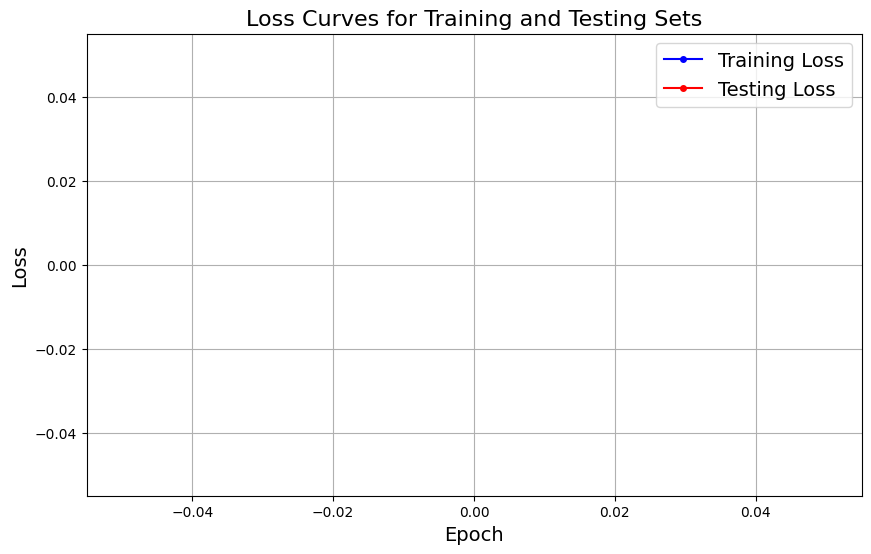

In [366]:
plot_loss_curves(losses_train, losses_test, file_name="mlp_loss_curves_large_2")

**Report what you observe on the training/test loss curves (related to a term we mentioned in the lecture)**

The toy moon dataset from Sklearn is a non-linearly separable dataset with two intertwined classes. The current MLP architecture with only two hidden layers may lack sufficient capacity to learn the complex patterns in the data, leading to high training loss and underfitting. Conversely, an excessively high capacity with multiple hidden layers may cause the model to overfit the training data, resulting in a low training loss but high test loss. Moreover, using Xavier or Glorot initialization for the weights instead of normal distribution initialization can enhance the model's learning capacity since the initialization helps to set the weights of the network to small random values that are inversely proportional to the square root of the number of input units in the previous layer. This ensures that the variance of the outputs of each layer remains consisten allowing gradients to flow through the network during backpropagation.


### Task 2: Data Preparation and Visualization

In [367]:
# prepare data for training and testing
def load_data(train=True):
    """Load train- test split for MNIST"""
    mnist = datasets.MNIST('../data',
                train=train,
                download=True)
    return mnist

In [368]:
# 1.1 Load MNIST dataset
# load train split
data_train = load_data(train=True)
data_test = load_data(train=False)

print(len(data_train))
print(len(data_test))

60000
10000


In [369]:
def plot_examples(data):
    """ Plot some examples and put their corresponding label on top as title."""
    train_set_array = np.fliplr(data.data.numpy()) # data is l-r flipped
    train_set_array_targets = data.targets.numpy()
    
    # set title for image with subplot

    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(10):
        axs[i].contourf(train_set_array[i], 5, cmap=plt.cm.Greys)
        axs[i].set_title(train_set_array_targets[i]) 
    
    # Set a single title for the entire figure
    fig.suptitle('MNIST Dataset', fontsize=20)

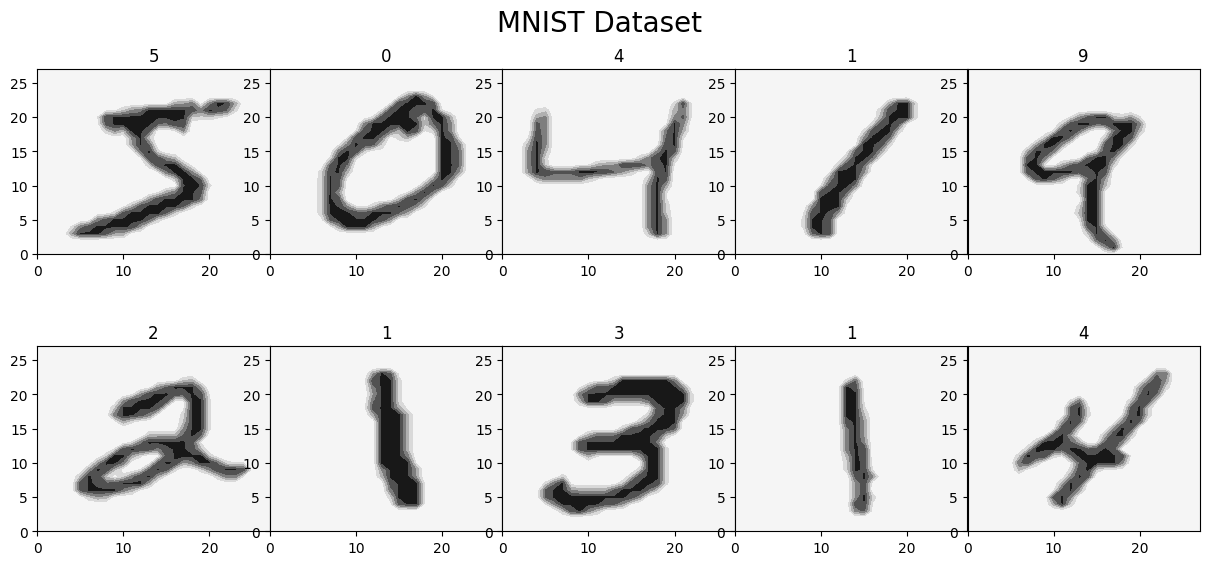

In [370]:
# 1.2 Plot some examples from the training set
plot_examples(data_train)

In [371]:
def plot_report(data: np.array) -> None:
    v_sum = np.sum(data)
    v_min = np.min(data)
    v_max = np.max(data)
    v_mean = np.mean(data)
    v_shape = data.shape
    v_dtype = data.dtype

    print("Report for train set")
    print(f"Train Sum: {v_sum}")
    print(f"Train Min: {v_min}")
    print(f"Train Max: {v_max}")
    print(f"Train Mean: {v_mean}")
    print(f"Train Shape: {v_shape}")
    print(f"Train Datatype: {v_dtype}")

In [372]:
# 1.3 Give a report about min, max, mean, and std of the training set
train_set_array = data_train.data.numpy() # data is l-r flipped
plot_report(train_set_array)

Report for train set
Train Sum: 1567298545
Train Min: 0
Train Max: 255
Train Mean: 33.318421449829934
Train Shape: (60000, 28, 28)
Train Datatype: uint8


In [373]:
def convert_mnist_to_vectors(data):
    '''Converts the ``[28, 28]`` MNIST images to vectors of size ``[28*28]``.
       It outputs mnist_vectors as a array with the shape of [N, 784], where
       N is the number of images in data.
    '''

    mnist_vectors = []
    labels = []

    for image, label in tqdm(data):
        img_array = np.asarray(image)
        img_array = np.reshape(img_array, -1) # reshape array to vector
        mnist_vectors.append(img_array)
        labels.append(label)

    # return as numpy arrays
    return np.array(mnist_vectors), labels


def normalise_data(data: np.array) -> np.array:
    """ Normalise vectors to be in a range of [-1, 1]
        Improves convergence of the model since gradients are in a similar range.
    """
    data = data.copy()
    return 2*(data - np.min(data))/np.ptp(data) - 1

In [374]:
# 2. Convert all images into plain vectors and process them to be centered around 0
mnist_vectors, labels = convert_mnist_to_vectors(data_train)

# normalize data
mnist_vectors = normalise_data(np.array(mnist_vectors))

print(mnist_vectors[:1].shape)
print(mnist_vectors.shape)

100%|██████████| 60000/60000 [00:00<00:00, 88591.87it/s]


(1, 784)
(60000, 784)


In [375]:
plot_report(mnist_vectors)

Report for train set
Train Sum: -40993291.16078458
Train Min: -1.0
Train Max: -0.0039215686274509665
Train Mean: -0.8714560195745021
Train Shape: (60000, 784)
Train Datatype: float64


In [376]:
# Normalised [-1,1]
norm_mnist_mean = np.mean(mnist_vectors)
print(f"Train Mean: {norm_mnist_mean}")

Train Mean: -0.8714560195745021


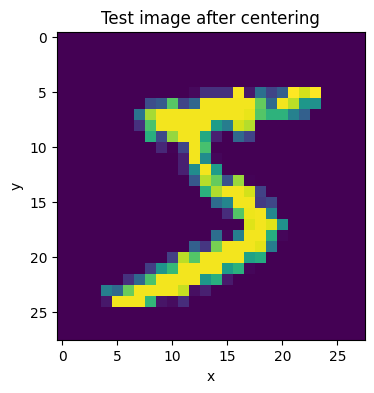

In [377]:
test_img = mnist_vectors[:1]
test_img = test_img.reshape((28, 28))
plt.imshow(test_img, interpolation='nearest')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test image after centering")
plt.show()

In [378]:
def do_pca(data):
    '''Returns matrix [784x784] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
    '''

    mnist_vectors, _ = convert_mnist_to_vectors(data)
    # prepare_data(mnist_vectors)

    # compute covariance matrix of data with shape [784x784]
    cov = np.cov(mnist_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues
    # the earlier eigenVectors have more information about the data
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    return sorted_eigenVectors.astype(np.float32).T

In [379]:
# 3. Run PCA on the MNIST dataset
eigenVectors = do_pca(data_train)

100%|██████████| 60000/60000 [00:00<00:00, 88511.39it/s]


<class 'numpy.ndarray'> (784, 784)


/var/folders/4h/v0fwv1zs4596mmdvwj516k840000gn/T/ipykernel_2075/3987593753.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  return sorted_eigenVectors.astype(np.float32).T


In [380]:
def plot_pcs(sorted_eigenVectors, num=10):
    '''Plots the first ``num`` eigenVectors as images.'''
    fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for i in range(num):
        img = sorted_eigenVectors[i,].reshape((28, 28))
        axs[i].contourf(img, 5, cmap=plt.cm.Oranges)
        axs[i].set_title(f"Principal Component {i}")
    
    # Set a single title for the entire figure
    fig.suptitle('Selected MNIST Dataset Eigenvectors', fontsize=20)

    # save plot to results folder
    plt.savefig(f"{RESULTS_PATH}/pca_components.png", dpi=300)

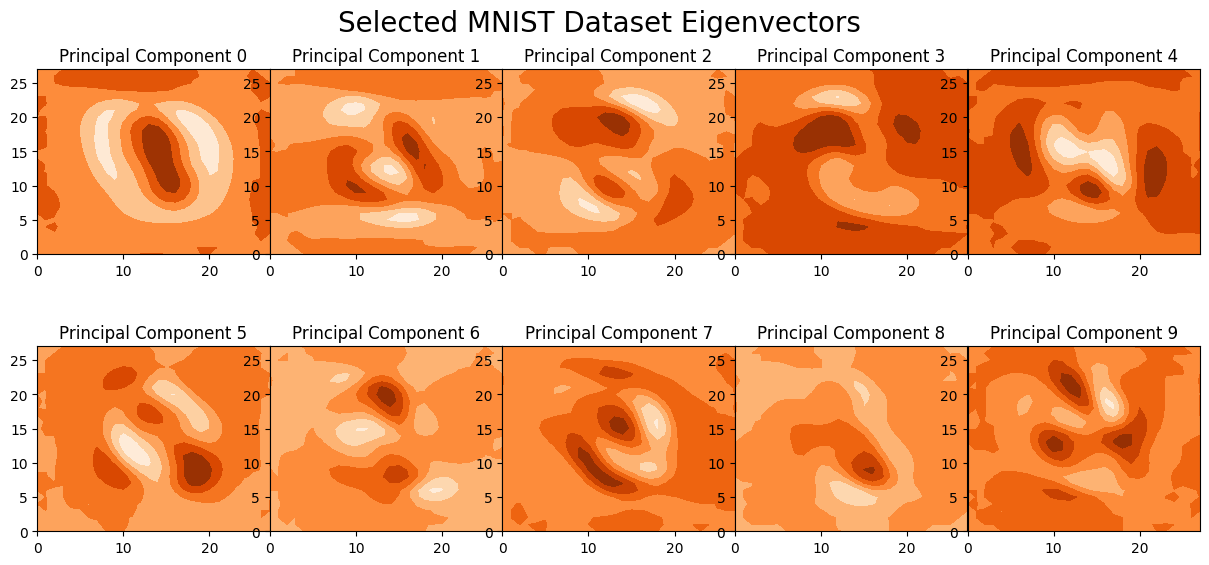

In [381]:
# 3.2 Plot the first 10 principal components
plot_pcs(eigenVectors)

**Explain what can be observed?**

The plot visualize the ten most important principal components, which allows to explain the greatest amount of variance in the original features. Thereby, PCA identifies directions (or principal components) along which the variation in the data is maximal. Hereby, it can be observed that the spread of the values is relatively large on the y-axis with relatively less spread (variance) on the x-axis. However, since the input data follows some wave-type structure (hand-written digits) after the projection the wave shapes also show up as distortion in the plots. Thereby, a linear correlation of the principal component values is not observable. The different values for the principal components do not show any clear linear relationship between the variance of the features in the dataset. We can derive that the classes are not linear seperable. The MNIST data further does not follow a multidimensional normal (Gaussian) distribution.

**What would you expect the principal components to look like, if the problem was easy?**

If the problem was easy a linear relationship, or strong linear correlation would be observable. However, the MNIST classes are not linearly seperable which makes the problem more challenging. Additionally, a large spread, or great variance is visible.

In [382]:
# create random colours
from random import randint

def generate_colors(amount: int) -> list:
    colors = []
    for i in range(amount):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    return colors

In [383]:
def project_vec_2Dspace(x, y):
    """ Use of the dot product to project vectors onto each other."""
    return np.dot(x, y)

In [384]:
def plot_projection(sorted_eigenVectors, data, subset=None, path=RESULTS_PATH):
    ''' Projects ``data`` onto the first two ``sorted_eigenVectors`` and makes
        a scatterplot of the resulting points
    '''
    if subset is None:
        N = len(list(data))
    else:
        N = subset

    # prepare data as vectors
    mnist_vectors, labels = convert_mnist_to_vectors(data)
    
    # projection of the first two vetors in 2D feature space
    pc1s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[0]) for x in mnist_vectors[:N,]])
    pc2s = np.array([project_vec_2Dspace(x, y=sorted_eigenVectors[1]) for x in mnist_vectors[:N,]])

    # get random colours
    unique_labels = np.unique(labels[:N])
    cdict = generate_colors(len(unique_labels))

    # plot all datapoints 
    fig, ax = plt.subplots()
    for g in unique_labels:
        ix = np.where(labels[:N] == g)
        x = list(pc1s[ix])
        y = list(pc2s[ix])
        ax.scatter(x, y, c=cdict[g], marker='.', label=f'class {g}')
    
    ax.legend()
    ax.grid()
    plt.title(f'Two Component PCA with {N} Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    fig.savefig(f'./{path}/pca.png', dpi=fig.dpi)

(2, 784)


100%|██████████| 60000/60000 [00:00<00:00, 90473.03it/s]


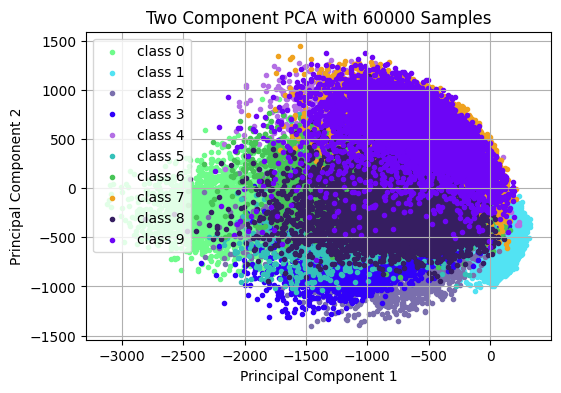

In [385]:
# 4. Project the MNIST vectors of the train set onto the two most important principal components
# find the two main important PCs, we can already separate the images somehow 
two_main_components = eigenVectors[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(sorted_eigenVectors=two_main_components, data=data_train)   

**Interpret the plot. What can it tell us about the MNIST dataset? Can you make a statement regarding the difficulty of MNIST digit classification problem?**

The diagram shows strong clusters and overlaps between the projected classes displaied, but little linear correlation within a class. Only very few classes can be separated, most are overlapping and mixed in the same PCA space. In this case, PCA may not well suited to capture non-linear relationships in a high-dimensional data set since it is itself a linear dimensionality reduction technique.

### Task 3: Defining, Training and Evaluating an MLP

In [386]:
# 1 build 5-layer MLP
class MultilayerPerceptron(nn.Module):
    """ The multilayer perceptron does a matrix multiplication of its 
        internal weights with the inputs and adds a bias in
        each layer. After that it activates the resulting vector.
        This can be done using the `Linear` layer. 
    """
    
    def __init__(self, size_hidden=100, size_out=10):
        """ Each hidden layer has 100 hidden units (output feature dimension).
            All hidden layers use ReLU activations.
        """
        super().__init__()
        # number of hidden nodes in each layer (100)
        # linear layer (784 -> hidden_1)
        self.fc1 = torch.nn.Linear(28*28, size_hidden) # Your Code here
        # linear layer (n_hidden -> n_hidden)
        self.fc2 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc3 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> n_hidden)
        self.fc4 = torch.nn.Linear(100, size_hidden)
        # linear layer (n_hidden -> size_out)
        self.out_layer = torch.nn.Linear(100, size_out)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # flatten the image, 
        # the -1 is a wildcard
        x = x.view(-1, 28*28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        # flatten the output signal
        out = out.view(out.size(0), -1)
        out = self.out_layer(out)
        
        # no softmax as multi-class 
        # classification not probabilities

        return out

In [387]:
class MnistVectors(torch.utils.data.Dataset):
    ''' A Pytorch Dataset, which does the same 
        data preparation as was done in the PCA exercise.
    '''

    def __init__(self, split='train'):
        super().__init__()
        # torch dataset with casting operation
        mnist_train = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_mnist_to_vectors(mnist_train)

            
    def __getitem__(self, idx):
        ''' Implements the ``[idx]`` method. Here we convert the numpy data to
            torch tensors.
        '''
        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)

In [388]:
# 3. Implement a function, which can report the accuracy of a batch of predictions in percent.

def batch_accuracy(prediction, label):
    """Uses labels to calculate the batch accuracy"""
    N = prediction.size(0)
    acc = prediction.eq(label.view_as(label)).sum().item()
    return (acc / N) * 100


def class_label(prediction):
    """ Transforms the output of the MultilayerPerceptron 
        into a scalar class label (index which matches predicted label: 0-9).
    """
    return prediction.argmax(dim=1)

def normalize_output(img):
    """ Normalizes the image to be in the range [0, 1]
        and converts it to a numpy array.
    """
    img = img - img.min()
    img = img / img.max()
    return img

In [389]:
# Visualize feature maps
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [390]:
# Visualize feature maps
act_fc1, act_fc2, act_fc3, act_fc4 = [], [], [], []
labels = []

In [391]:
def get_feature_maps(model, dataset=None, use_gpu=False):
    """ Get the feature maps of the model for a given dataset."""
    # define hook
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # register hooks
    model.fc1.register_forward_hook(get_activation('fc1'))
    model.fc2.register_forward_hook(get_activation('fc2'))
    model.fc3.register_forward_hook(get_activation('fc3'))
    model.fc4.register_forward_hook(get_activation('fc4'))

    if not dataset:
        dataset = datasets.MNIST(
        root='../data',
        train=False,
        transform=transforms.ToTensor()
    )

    count = 0
    with torch.no_grad():
        for data_sample, label in dataset:
            
            data_sample = np.reshape(data_sample, -1)
            data_sample.unsqueeze_(0)

            if use_gpu:
                data_sample = data_sample.cuda()
                label = label.cuda()
                
            pred = model(data_sample)

            act1 = activation['fc1'].squeeze()
            act2 = activation['fc2'].squeeze()
            act3 = activation['fc3'].squeeze()
            act4 = activation['fc4'].squeeze()

            # collect activated feature maps
            act_fc1.append(act1.detach().cpu().numpy())
            act_fc2.append(act2.detach().cpu().numpy())
            act_fc3.append(act3.detach().cpu().numpy())
            act_fc4.append(act4.detach().cpu().numpy())

            # collect all labels
            labels.append(label)
            count += 1

        print(f" Done after {count} steps!")

In [392]:
def validate(test, model, criterion, use_gpu=False):
        test_accuracies = []
        test_losses = []
        
        model.eval()
        
        with torch.no_grad():
            for idx, [test_examples, test_labels] in enumerate(tqdm(test, desc='Test')):
                if use_gpu:
                    test_examples = test_examples.cuda()
                    test_labels = test_labels.cuda()
                
                test_prediction = model(test_examples)
                
                # evaluation
                test_loss = criterion(test_prediction, test_labels).data.item()
                test_acc = batch_accuracy(class_label(test_prediction), test_labels)

                if (idx % 10) == 0:
                    print('Test Batch Accuracy: {}%, Test Loss: {}'.format(test_acc, test_loss))
                
                test_accuracies.append(test_acc) # per batch
                test_losses.append(test_loss)

        # Use the batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

        print('Mean Validation Accuracy: {}%'.format(np.mean(test_accuracies)))
        print('Mean Validation Loss: {}%'.format(np.mean(test_losses)))

        plt.plot(test_accuracies)

In [393]:
def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    model = MultilayerPerceptron()
    
    TrainData = MnistVectors()
    TestData = MnistVectors('test')

    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    
    Dl = DataLoader(TrainData, batch_size=32, shuffle=True)
    testDl = DataLoader(TestData, batch_size=32, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    # not use any activation function on the output layer! (Do you know why?) 
    criterion = nn.CrossEntropyLoss()
    
    if use_gpu:
        model.cuda()
        criterion.cuda()
    
    for epoch in tqdm(range(5), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            
            optimizer.zero_grad()
            
            prediction = model(example)
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time to time.
            if (step % 375) == 0:
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
        
        # checkpoints to reuse model weights
        torch.save(model.state_dict(), 'perceptron_{}.ckpt'.format(step))

    # Now validate on the whole test set
    validate(testDl, model, criterion, use_gpu)

    # If you need to load the checkpoint instanciate your model and the
    # load the state dict from a checkpoint:
    # model = MultilayerPerceptron()
    # model.load_state_dict(torch.load(perceptron_3750.ckpt))
    # Make sure to use the latest checkpoint by entering the right number.

    ######################################
    ######      Code for task 4     ######
    ######################################

    get_feature_maps(model, use_gpu=use_gpu)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]   

Batch Accuracy: 3.125%, Loss: 3.1358180046081543



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 84.375%, Loss: 0.5519012212753296



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]              

Batch Accuracy: 96.875%, Loss: 0.08891161531209946



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 90.625%, Loss: 0.19568373262882233



Epoch:   0%|          | 0/5 [00:01<?, ?it/s]               

Batch Accuracy: 96.875%, Loss: 0.088953897356987


Epoch:  20%|██        | 1/5 [00:02<00:08,  2.05s/it]

Batch Accuracy: 100.0%, Loss: 0.03316746652126312



Epoch:  20%|██        | 1/5 [00:02<00:08,  2.05s/it]      

Batch Accuracy: 100.0%, Loss: 0.025929996743798256



Epoch:  20%|██        | 1/5 [00:02<00:08,  2.05s/it]      

Batch Accuracy: 87.5%, Loss: 0.4754013419151306



Epoch:  20%|██        | 1/5 [00:03<00:08,  2.05s/it]       

Batch Accuracy: 100.0%, Loss: 0.04189357906579971



Epoch:  20%|██        | 1/5 [00:03<00:08,  2.05s/it]       

Batch Accuracy: 100.0%, Loss: 0.039214279502630234


Epoch:  40%|████      | 2/5 [00:04<00:06,  2.08s/it]

Batch Accuracy: 100.0%, Loss: 0.019654279574751854



Epoch:  40%|████      | 2/5 [00:04<00:06,  2.08s/it]      

Batch Accuracy: 90.625%, Loss: 0.34203627705574036



Epoch:  40%|████      | 2/5 [00:05<00:06,  2.08s/it]      

Batch Accuracy: 100.0%, Loss: 0.06499850004911423



Epoch:  40%|████      | 2/5 [00:05<00:06,  2.08s/it]       

Batch Accuracy: 100.0%, Loss: 0.049340296536684036



Epoch:  40%|████      | 2/5 [00:06<00:06,  2.08s/it]       

Batch Accuracy: 100.0%, Loss: 0.02157103456556797


Epoch:  60%|██████    | 3/5 [00:06<00:04,  2.26s/it]

Batch Accuracy: 100.0%, Loss: 0.06679408252239227



Epoch:  60%|██████    | 3/5 [00:07<00:04,  2.26s/it]      

Batch Accuracy: 100.0%, Loss: 0.011200418695807457



Epoch:  60%|██████    | 3/5 [00:07<00:04,  2.26s/it]      

Batch Accuracy: 93.75%, Loss: 0.11141953617334366



Epoch:  60%|██████    | 3/5 [00:08<00:04,  2.26s/it]       

Batch Accuracy: 96.875%, Loss: 0.10492761433124542



Epoch:  60%|██████    | 3/5 [00:08<00:04,  2.26s/it]       

Batch Accuracy: 96.875%, Loss: 0.07901377230882645


Epoch:  80%|████████  | 4/5 [00:09<00:02,  2.49s/it]

Batch Accuracy: 96.875%, Loss: 0.05551590397953987



Epoch:  80%|████████  | 4/5 [00:10<00:02,  2.49s/it]      

Batch Accuracy: 96.875%, Loss: 0.059969499707221985



Epoch:  80%|████████  | 4/5 [00:10<00:02,  2.49s/it]      

Batch Accuracy: 100.0%, Loss: 0.010069087147712708



Epoch:  80%|████████  | 4/5 [00:11<00:02,  2.49s/it]       

Batch Accuracy: 100.0%, Loss: 0.008748723194003105



Epoch:  80%|████████  | 4/5 [00:11<00:02,  2.49s/it]       

Batch Accuracy: 93.75%, Loss: 0.09624660760164261


Test: 100%|██████████| 313/313 [00:00<00:00, 2080.49it/s]


Test Batch Accuracy: 100.0%, Test Loss: 0.02855250984430313
Test Batch Accuracy: 96.875%, Test Loss: 0.08206547796726227
Test Batch Accuracy: 96.875%, Test Loss: 0.06988582015037537
Test Batch Accuracy: 96.875%, Test Loss: 0.0768774151802063
Test Batch Accuracy: 87.5%, Test Loss: 0.1790928840637207
Test Batch Accuracy: 90.625%, Test Loss: 0.24279040098190308
Test Batch Accuracy: 93.75%, Test Loss: 0.10226026922464371
Test Batch Accuracy: 100.0%, Test Loss: 0.0058402447029948235
Test Batch Accuracy: 96.875%, Test Loss: 0.0828879252076149
Test Batch Accuracy: 96.875%, Test Loss: 0.02953249029815197
Test Batch Accuracy: 100.0%, Test Loss: 0.015939995646476746
Test Batch Accuracy: 93.75%, Test Loss: 0.2977997064590454
Test Batch Accuracy: 93.75%, Test Loss: 0.3777996599674225
Test Batch Accuracy: 93.75%, Test Loss: 0.21277828514575958
Test Batch Accuracy: 96.875%, Test Loss: 0.14344428479671478
Test Batch Accuracy: 93.75%, Test Loss: 0.21697771549224854
Test Batch Accuracy: 100.0%, Test Lo

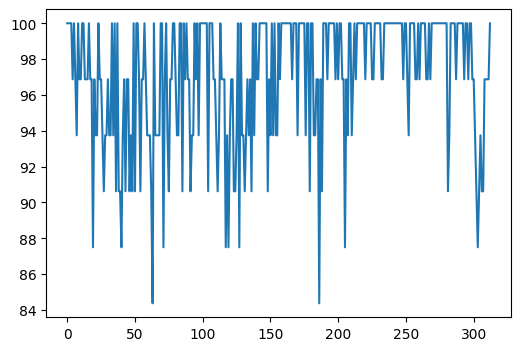

In [394]:
train(use_gpu=True if torch.cuda.is_available() else False)

#### Task 4: Visualizing MLP Features

In [395]:
# 1. MNIST images of the test split, or if you have limited computational resource for a subset of at least 1000 image
print(np.asarray(act_fc1).shape)

(10000, 100)


In [396]:
# 2. find PCA of vectors and project feature maps onto the first two principal components
def convert_act_to_vectors(data):
    '''Converts the activated feature maps to vectors of size ``[n*m]``.
       It outputs mnist_vectors as a array with the shape of [N, n*m], where
       N is the number of maps in data.
    '''

    act_vectors = []

    for act in tqdm(data):
        act_array = np.asarray(act)
        act_array = np.reshape(act_array, -1) # reshape array to vector
        act_vectors.append(act_array)
    
    # return as numpy arrays
    return norm_data(np.array(act_vectors))

In [397]:
def do_pca_actm(data):
    '''Returns matrix [nxm] whose columns are the sorted eigenvectors.
       Eigenvectors (prinicipal components) are sorted according to their
       eigenvalues in decreasing order.
       >>> PCA compresses the input data into its representation.
    '''

    actm_vectors = convert_act_to_vectors(data)
    # prepare_data(actm_vectors)

    # compute covariance matrix of data
    cov = np.cov(actm_vectors.T)

    # compute eigenvalues and vectors
    eigVals, eigVec = np.linalg.eig(cov)

    # sort eigenVectors by eigenValues descending
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    print(type(sorted_eigenVectors), sorted_eigenVectors.shape)
    
    return sorted_eigenVectors.astype(np.float64).T

In [398]:
pca_act_fc1 = do_pca_actm(act_fc1)
pca_act_fc2 = do_pca_actm(act_fc2)
pca_act_fc3 = do_pca_actm(act_fc3)
pca_act_fc4 = do_pca_actm(act_fc4)

print(pca_act_fc1.shape)
print(pca_act_fc2.shape)
print(pca_act_fc3.shape)
print(pca_act_fc4.shape)

100%|██████████| 10000/10000 [00:00<00:00, 1308593.54it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 285867.42it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 1005129.29it/s]


<class 'numpy.ndarray'> (100, 100)


100%|██████████| 10000/10000 [00:00<00:00, 441384.88it/s]

<class 'numpy.ndarray'> (100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


(2, 100)


10000it [00:00, 229563.24it/s]


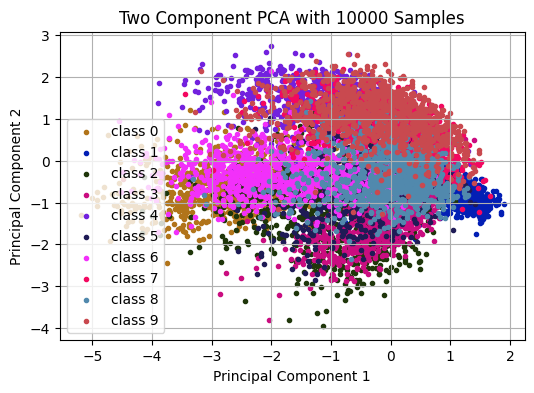

In [399]:
# 3. Make a scatter plot of the projected feature maps onto the first two principal components
# find the two main important PCs
two_main_components = pca_act_fc1[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc1, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1247525.06it/s]


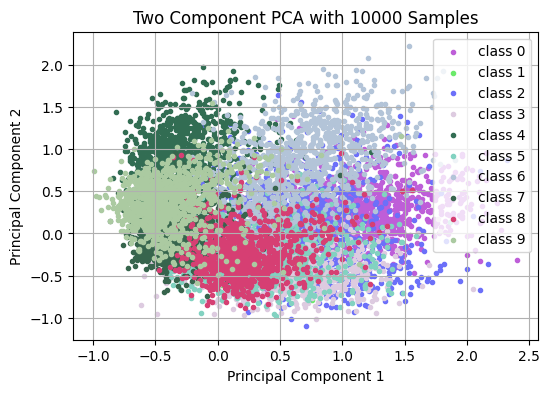

In [400]:
# find the two main important PCs
two_main_components = pca_act_fc2[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc2, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1267123.05it/s]


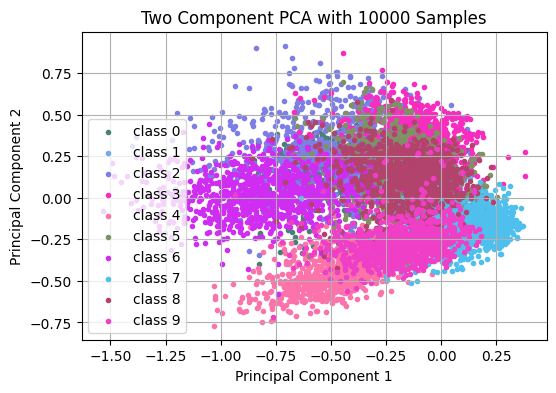

In [401]:
# find the two main important PCs
two_main_components = pca_act_fc3[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc3, labels), subset=len(labels))

(2, 100)


10000it [00:00, 1295818.09it/s]


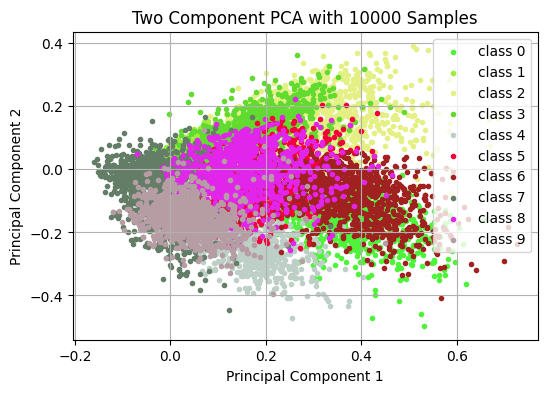

In [402]:
# find the two main important PCs
two_main_components = pca_act_fc4[:2,] # start_index: end_index, 
print(two_main_components.shape)

plot_projection(two_main_components, zip(act_fc4, labels), subset=len(labels))

**Compare the plots to the scatter plot from task 2. What has changed, what is similar?**

The PCA plots show a progressive scattering of salient features along the x- and y-axis through the model layers. The later layers show distinct projections per class into various clusters. This is because the later layers of the model learn more complex and abstract features of the data, which can better separate the different classes or categories.

**Do you believe that the MLP is a suitable method for MNIST digit classification? Provide an explanation.**

MLPs are relatively simple and suitable for structured data, making them a good baseline model for MNIST digit classification. However, CNNs are better suited for processing large image datasets as they can capture spatial relationships between pixels and develop an internal representation of the training dataset. CNNs also use weight sharing, making them more parameter-efficient than MLPs. Therefore, while an MLP can be used as a starting point, a CNN is likely to achieve better performance on the MNIST dataset.
